In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# import .py file
import Nrl as nrl

warnings.filterwarnings('ignore')


In [3]:
### load data ###
path='/Users/dylanjorling/UCLA/418proj/'
name='box_office_data_final.csv'
data=pd.read_csv(path+name, index_col='id')
data['new_genres'] = data['new_genres'].apply(lambda x: str(x).strip())
#pd.options.display.max_columns = None
data = data[(data['year'] >= 1990) & (data['year'] < 2020)]
data.head()

,title,fullTitle,type,year,date,runtime,plot,awards,directors,writers,...,award_noms,dir_pop,wr_pop,star_power,company_size,release_month,inflation_index,adj_budget,gross_profit_adj,new_genres
id,,,,,,,,,,,,,,,,,,,,,
tt0035423,Kate & Leopold,Kate & Leopold (2001),Movie,2001,2001-12-25,118.0,Kate and her actor brother live in N.Y. in the...,"Nominated for 1 Oscar, 1 win & 5 nominations t...",James Mangold,"Steven Rogers, James Mangold",...,6,10,3.500000,25,29,December,1.696718,8.144249e+07,4.754044e+07,Fantasy
tt0099005,Air America,Air America (1990),Movie,1990,1990-08-10,113.0,Air America was the CIAs private airline opera...,"Awards, 1 nomination",Roger Spottiswoode,"Christopher Robbins, John Eskow, Richard Rush",...,1,5,1.000000,40,11,August,2.358908,8.256179e+07,-3.629725e+06,War
tt0099044,Another 48 Hrs.,Another 48 Hrs. (1990),Movie,1990,1990-06-08,95.0,With a pending old debt from the past and the ...,0,Walter Hill,"John Fasano, Roger Spottiswoode, Jeb Stuart",...,0,6,1.666667,31,8,June,2.358908,8.963851e+07,2.724987e+08,Comedy
tt0099052,Arachnophobia,Arachnophobia (1990),Movie,1990,1990-07-18,109.0,A species of South American killer spider hitc...,"Awards, 2 wins & 5 nominations",Frank Marshall,"Don Jakoby, Al Williams, Wesley Strick",...,7,4,3.333333,23,52,July,2.358908,5.189598e+07,7.361723e+07,Thriller
tt0099077,Awakenings,Awakenings (1990),Movie,1990,1991-01-11,121.0,1969. Dr. Malcolm Sayer is hired as a clinical...,"Nominated for 3 Oscars, 6 wins & 11 nomination...",Penny Marshall,"Oliver Sacks, Steven Zaillian",...,17,4,4.000000,43,250,January,2.238053,6.937965e+07,4.721504e+07,Biography


In [3]:
# set up features and target
# features: runtime, rating, 
features = data[['runtime', 'rating', 'new_genres', 'release_month', 'adj_budget',
                 'dir_pop', 'wr_pop', 'star_power', 'company_size']]
features.head()
targets = data['gross_profit_adj']

In [4]:
# will need to one-hot encode genre, release_month and rating....I also am going to make cosize into a factor
# one-hot rating
features['rating'].value_counts() # going to put not rated->R and G->PG
features['rating'].replace({'G':'PG/G',
                           'PG': 'PG/G',
                           'Not Rated': 'R'},
                          inplace=True)
features['rating'].value_counts()
one_hot_ratings = features['rating'].str.get_dummies()
print(one_hot_ratings.head())

           PG-13  PG/G  R
id                       
tt0035423      1     0  0
tt0099005      0     0  1
tt0099044      0     0  1
tt0099052      1     0  0
tt0099077      1     0  0


In [5]:
# one-hot genre
features['new_genres'].value_counts()
features['new_genres'].replace({'Action': 'Action/Adventure',
                               'Adventure': 'Action/Adventure',
                               'Crime': 'Thriller',
                               'Horror': 'Thriller',
                                'Romance': 'Misc',
                               'Fantasy': 'Action/Adventure',
                               'Sci-Fi': 'Action/Adventure',
                               'Family': 'Misc',
                                'Mystery': 'Thriller',
                               'Biography': 'Drama',
                               'Animation': 'Misc',
                               'History': 'Drama',
                               'Music': 'Drama',
                               'Sport': 'Drama',
                               'War': 'Drama',
                               'Musical': 'Misc',
                               'Western': 'Drama',
                               'Film-Noir': 'Misc'},
                              inplace=True)
features['new_genres'].value_counts()
one_hot_genres = features['new_genres'].str.get_dummies()
print(one_hot_genres.head())

           Action/Adventure  Comedy  Drama  Misc  Thriller
id                                                        
tt0035423                 1       0      0     0         0
tt0099005                 0       0      1     0         0
tt0099044                 0       1      0     0         0
tt0099052                 0       0      0     0         1
tt0099077                 0       0      1     0         0


In [6]:
# one-hot release period
features['release_month'].replace({'January': 'nov_to_jan',
                                  'February': 'feb_to_apr',
                                  'March': 'feb_to_apr',
                                  'April': 'feb_to_apr',
                                  'May': 'may_to_july',
                                  'June': 'may_to_july',
                                  'July': 'may_to_july',
                                  'August': 'aug_to_oct',
                                  'September': 'aug_to_oct',
                                  'October': 'aug_to_oct',
                                  'November': 'nov_to_jan',
                                  'December': 'nov_to_jan'},
                                inplace=True)
features['release_month'].value_counts()
one_hot_release_period = features['release_month'].str.get_dummies()
print(one_hot_release_period.head())

           aug_to_oct  feb_to_apr  may_to_july  nov_to_jan
id                                                        
tt0035423           0           0            0           1
tt0099005           1           0            0           0
tt0099044           0           0            1           0
tt0099052           0           0            1           0
tt0099077           0           0            0           1


In [7]:
# cut and one-hot co size
features['company_size'].quantile([0.25, 0.5, 0,.75]) # cut at 8, 44, 179
features['company_size'] = pd.cut(features['company_size'],
                                  bins=[0,8,44,179, 286],
                                  labels=['small', 'medium', 'large', 'giant'])

one_hot_cosize = features['company_size'].str.get_dummies()
one_hot_cosize.head()

,giant,large,medium,small
id,,,,
tt0035423,0,0,1,0
tt0099005,0,0,1,0
tt0099044,0,0,0,1
tt0099052,0,1,0,0
tt0099077,1,0,0,0


In [8]:
# normalize numerical values and join one-hots
# vars to join: one_hot_ratings, one_hot_genres, one_hot_release_period, one_hot_cosize
numerical = features[['runtime', 'dir_pop', 'wr_pop', 'star_power', 'adj_budget']].values
scaler = StandardScaler().fit(numerical)
normalized = scaler.transform(numerical)
feats  = np.concatenate([normalized,
                         one_hot_ratings.values,
                         one_hot_genres.values,
                         one_hot_release_period.values,
                         one_hot_cosize.values],
                        axis=1)
scaler_y = StandardScaler().fit(targets.values.reshape(-1, 1))
targs = scaler_y.transform(targets.values.reshape(-1, 1))
print(feats.shape, targs.shape)

# split data and convert to torch tensor
X_train, X_test, y_train, y_test = train_test_split(feats, targs, test_size = 0.20, random_state=30)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(3338, 21) (3338, 1)
(2670, 21) (668, 21) (2670, 1) (668, 1)


In [9]:
## Prep data for training ##

batch_size=64

train_dataset = nrl.imdb_Dataset(X_train, y_train)
test_dataset = nrl.imdb_Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False)


X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Targets shape:", y.shape)


Features shape: torch.Size([64, 21])
Targets shape: torch.Size([64, 1])


In [10]:
####### Fully Connected Net Training #########
loss = nn.MSELoss()
lr = 0.0001
out_feats=1

model = nrl.Net()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 150

train_losses = []
test_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch}\n---------")
    train_loss = nrl.train_model(train_loader,
                             model=model,
                             loss_function=loss,
                             optimizer=optimizer)
    
    print('Train loss: {}'.format(train_loss))
    
    train_losses.append(train_loss)
    
    test_loss = nrl.test_model(test_loader,
                          model=model,
                          loss_function=loss)
    
    test_losses.append(test_loss)
    
    print('Test loss: {}'.format(test_loss))
    
df_predictions = nrl.get_pred_df(data['gross_profit_adj'], test_loader, y_test, model)
mse = df_predictions['squared_error'].mean()
null = df_predictions['Profit_actual'].var()

print('The model produced MSE of {} compared to null model Var of {}'.format(mse, null))



Epoch 0
---------
Train loss: 0.933781739501726
Test loss: 1.1113036979328503
Epoch 1
---------
Train loss: 0.8556436612492516
Test loss: 1.0430379184809597
Epoch 2
---------
Train loss: 0.8035299951831499
Test loss: 0.9868917248465798
Epoch 3
---------
Train loss: 0.7572932782627287
Test loss: 0.9427614537152377
Epoch 4
---------
Train loss: 0.7276664908443179
Test loss: 0.9060040305961262
Epoch 5
---------
Train loss: 0.6957563282478423
Test loss: 0.8763507116924633
Epoch 6
---------
Train loss: 0.6759388961252712
Test loss: 0.8547533425417814
Epoch 7
---------
Train loss: 0.6637545930487769
Test loss: 0.8366079384630377
Epoch 8
---------
Train loss: 0.645820065623238
Test loss: 0.8224819573489103
Epoch 9
---------
Train loss: 0.6364672137867837
Test loss: 0.8109415959228169
Epoch 10
---------
Train loss: 0.6318905169055575
Test loss: 0.8013870716094971
Epoch 11
---------
Train loss: 0.6227909809067136
Test loss: 0.7936793701215223
Epoch 12
---------
Train loss: 0.6193110080701965
Te

Train loss: 0.5200804464873814
Test loss: 0.7425076175819744
Epoch 106
---------
Train loss: 0.5236387515351886
Test loss: 0.7435981197790666
Epoch 107
---------
Train loss: 0.5173958653495425
Test loss: 0.7434388724240389
Epoch 108
---------
Train loss: 0.5160821977825392
Test loss: 0.7433643910017881
Epoch 109
---------
Train loss: 0.515382452734879
Test loss: 0.7433988749980927
Epoch 110
---------
Train loss: 0.5206106085152853
Test loss: 0.7435304820537567
Epoch 111
---------
Train loss: 0.5147089784344038
Test loss: 0.744331116026098
Epoch 112
---------
Train loss: 0.5163750275969505
Test loss: 0.7437927506186746
Epoch 113
---------
Train loss: 0.5156889965846425
Test loss: 0.7444868331605737
Epoch 114
---------
Train loss: 0.5144103265234402
Test loss: 0.7443126738071442
Epoch 115
---------
Train loss: 0.5127971218455405
Test loss: 0.7434964748946103
Epoch 116
---------
Train loss: 0.5123961227280753
Test loss: 0.7443004223433408
Epoch 117
---------
Train loss: 0.5126612771834645

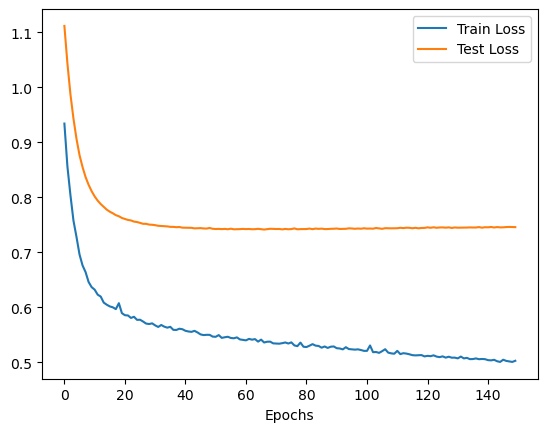

In [11]:
nrl.plot_losses(train_losses, test_losses)

In [13]:
# save predictions
df_predictions.to_csv('NN_preds.csv')

In [14]:
## check linear reg##
reg = LinearRegression()
reg.fit(X_train , y_train)
predictions = reg.predict(X_test)
preds_actual = (predictions * data['gross_profit_adj'].std()) + data['gross_profit_adj'].mean()
y_test_actual = (y_test * data['gross_profit_adj'].std()) + data['gross_profit_adj'].std()
mse = mean_squared_error(y_test_actual, preds_actual)
rmse = mse ** 0.5
null = y_test_actual.var()

r2=r2_score(y_test,predictions)
print('r2 score is {}'.format(r2))
print('mean_sqrd_error is {}'.format(mse))
print('null model variance is {}'.format(null))

r2 score is 0.3487684467890414
mean_sqrd_error is 6.99813573699647e+16
null model variance is 8.47614614205905e+16


In [15]:
####### User Inputs ##########
runtime = 120
director = ''
writor = ''
star_1 = ''
star_2 = ''
star_3 = ''
budget = ''
prod_size = 'medium'
genre = 'Comedy'
rating = 'R'
month = 'August'

In [16]:
## Save Nueral Network Model for upload to dashboard ##
torch.save(model, 'neural_net.pth')

In [53]:
month_dict = {'January': 'nov_to_jan',
              'February': 'feb_to_apr',
              'March': 'feb_to_apr',
              'April': 'feb_to_apr',
              'May': 'may_to_july',
              'June': 'may_to_july',
              'July': 'may_to_july',
              'August': 'aug_to_oct',
              'September': 'aug_to_oct',
              'October': 'aug_to_oct',
              'November': 'nov_to_jan',
              'December': 'nov_to_jan'}


rp = pd.DataFrame(np.zeros((1, 4)), columns = ['aug_to_oct', 'feb_to_apr', 'may_to_july', 'nov_to_jan'])
release_period = month_dict['January']
rp[release_period] = 1.0
rp

,aug_to_oct,feb_to_apr,may_to_july,nov_to_jan
0,0.0,0.0,0.0,1.0
